# Predicting Heart Disease Using Age, Sex, and Chest Pain Type

### Introduction: 

Heart disease remains one of the most critical health challenges worldwide, causing significant mortality and morbidity. Early identification of heart disease is vital for initiating timely interventions and improving patient outcomes. This project aims to utilize the Cleveland heart disease dataset to develop a predictive model for heart disease presence based on specific medical attributes: age, sex, and chest pain type.

The question we will try to answer is: **"Can we predict the presence of heart disease in patients based on their age, sex, and chest pain type?"**

Heart disease prediction involves analyzing various factors that contribute to the condition. Age is a crucial factor, as the risk of heart disease increases with age. Sex differences also play a significant role, with males generally at higher risk. Chest pain type (angina) provides immediate clues about heart health; specific types of chest pain are more strongly associated with heart disease.e.


### Dataset Description
We will use the **processed.cleveland.data** dataset, part of a larger collection of heart disease datasets compiled from different locations. The dataset includes 14 attributes related to patient demographics and medical information, but for this project, we will focus on:

- Age: The age of the patient.
- Sex: Gender of the patient (1 = male; 0 = female).
- Chest pain type (cp): Categorized as:
    - Typical angina
    - Atypical angina
    - Non-anginal pain
    - Asymptomatic

**Diagnosis of heart disease (num)**: Values range from 0 (no disease) to 4, indicating the presence of heart disease.


#### Loading & Cleaning The Data

In [52]:
# Load necessary libraries
library(tidyverse)
library(tidymodels)
library(repr)
library(knitr)
library(rsample)
options(repr.matrix.max.rows = 6)

# Load the dataset & name the columns
col_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
               "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

heart_data <- read_csv("data/heart_disease/processed.cleveland.data", col_names = col_names, na = "?")

# Display the first few rows of the dataset
(heart_data)

# Preliminary cleaning: Convert necessary columns to factors
heart_data <- heart_data |>
  select(age, sex, cp, num) |>
  mutate(sex = as.factor(sex),
         cp = as.factor(cp),
         num = as.factor(num))

# Count of observations in each class
count_data <- heart_data |>
  group_by(num) |>
  summarise(count = n())

print(count_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1,7,3
57,0,2,130,236,0,2,174,0,0.0,2,1,3,1
38,1,3,138,175,0,0,173,0,0.0,1,NA,3,0


# A tibble: 5 × 2
  num   count
  <fct> <int>
1 0       164
2 1        55
3 2        36
4 3        35
5 4        13


#### Tidy the Data and Split into Training and Testing Sets

In [56]:
# Splitting the data into training and testing sets
set.seed(123)
split <- initial_split(heart_data, prop = 0.75, strata = num)
training_data <- training(split)
testing_data <- testing(split)

# Displaying the training dataset
(training_data)

age,sex,cp,num
<dbl>,<fct>,<fct>,<fct>
63,1,1,0
56,1,2,0
57,0,4,0
⋮,⋮,⋮,⋮
55,0,4,3
59,1,4,3
57,1,4,3


#### Summarize the Training Data

In [58]:
# Summarize the data: means of predictor variables and rows with missing data
summary_table <- training_data |>
  summarise(
    Count = n(),
    `Mean Age` = mean(age, na.rm = TRUE),
    `Male Percentage` = mean(sex == 1, na.rm = TRUE) * 100,
    `Female Percentage` = mean(sex == 0, na.rm = TRUE) * 100,
    `Typical Angina Percentage` = mean(cp == 1, na.rm = TRUE) * 100,
    `Atypical Angina Percentage` = mean(cp == 2, na.rm = TRUE) * 100,
    `Non-anginal Pain Percentage` = mean(cp == 3, na.rm = TRUE) * 100,
    `Asymptomatic Percentage` = mean(cp == 4, na.rm = TRUE) * 100,
    `Heart Disease Presence` = sum(num == "1" | num == "2" | num == "3" | num == "4", na.rm = TRUE),
    `Missing Data Rows` = sum(is.na(age) | is.na(sex) | is.na(cp))
  )

(summary_table) # Display the Results

Count,Mean Age,Male Percentage,Female Percentage,Typical Angina Percentage,Atypical Angina Percentage,Non-anginal Pain Percentage,Asymptomatic Percentage,Heart Disease Presence,Missing Data Rows
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
225,54.59111,68,32,7.111111,17.33333,28,47.55556,103,0


In the context of developing a predictive model for heart disease presence based on age, sex, and chest pain type, the summary table offers key insights into the demographic and clinical characteristics of the training dataset, essential for informed analysis and modeling decisions.

**Summary Table Contents:**

**Count:**

- The count represents the total number of patients in the training dataset, providing insight into the dataset's size and sample adequacy. With 225 patients, we have a substantial dataset for training our predictive model on heart disease presence.

**Mean Age:**

- Mean age signifies the average age of patients in the dataset. Age is a critical risk factor for heart disease, and understanding the average age of patients helps contextualize the demographic composition of our study population. The mean age of approximately 54.59 years suggests that our dataset covers a range of ages relevant to heart disease analysis.

**Male Percentage (68%) and Female Percentage (32%):**

- These percentages represent the distribution of male and female patients in the dataset. Gender differences are significant in heart disease research, with males often at higher risk. The higher percentage of male patients (68%) in our dataset aligns with this trend, indicating the dataset's representation of gender diversity.

**Percentage of Typical Angina (7.11%), Atypical Angina (17.33%), Non-anginal Pain (28%), and Asymptomatic (47.56%):**

- These percentages depict the distribution of chest pain types among patients. Chest pain type is a crucial symptom in diagnosing heart disease, with different types indicating varying levels of severity. Understanding the distribution of chest pain types helps in risk stratification and diagnosis. For instance, the high percentage of asymptomatic patients (47.56%) suggests the presence of silent heart disease cases in our dataset.

**Missing Data Rows (0):**

- This metric indicates the absence of rows with missing data in the dataset. Complete data is essential for accurate analysis and model building. With zero missing data rows, we can proceed with confidence in the dataset's integrity, reducing potential biases in our predictive modeling efforts.

This table helps us understand the overall distribution of key variables in the training dataset, including the completeness of the data, which is essential for building a predictive model.

#### Data Visualization

Now, let's create the relevant visualizations using the training data: 

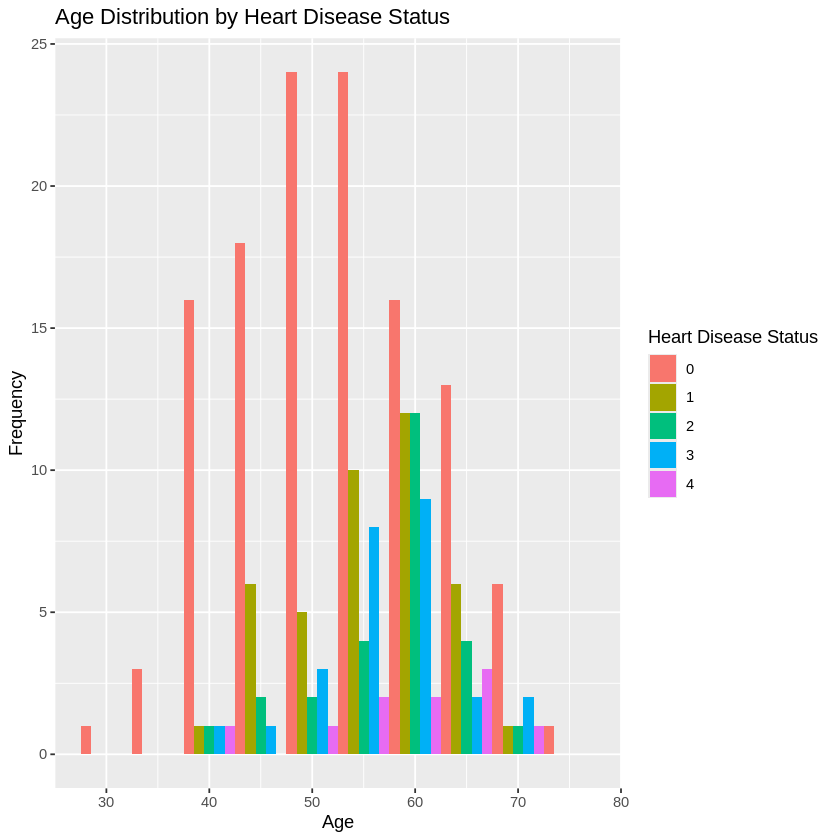

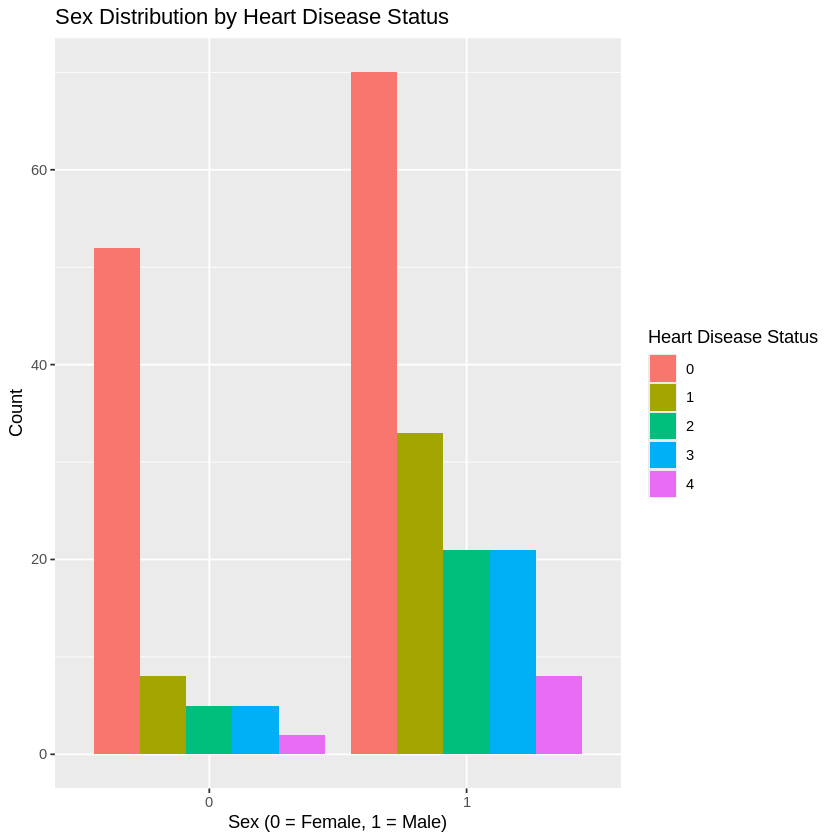

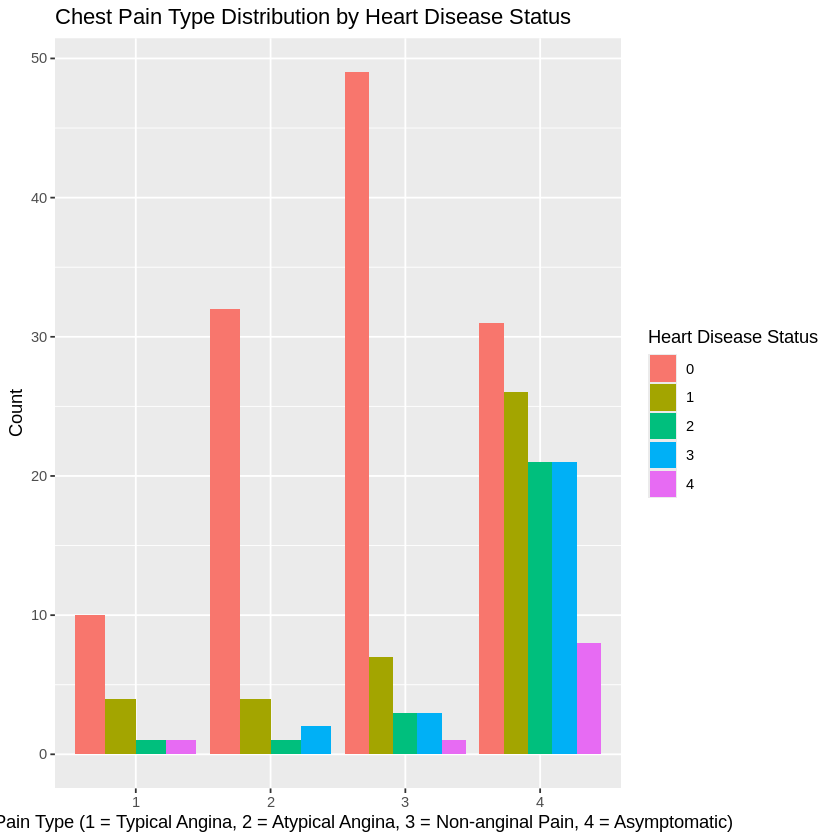

In [16]:
# Visualization: Age distribution by heart disease status
ggplot(training_data, aes(x = age, fill = num)) +
  geom_histogram(binwidth = 5, position = "dodge") +
  labs(title = "Age Distribution by Heart Disease Status",
       x = "Age",
       y = "Frequency",
       fill = "Heart Disease Status")

# Visualization: Sex distribution by heart disease status
ggplot(training_data, aes(x = sex, fill = num)) +
  geom_bar(position = "dodge") +
  labs(title = "Sex Distribution by Heart Disease Status",
       x = "Sex (0 = Female, 1 = Male)",
       y = "Count",
       fill = "Heart Disease Status")

# Visualization: Chest pain type distribution by heart disease status
ggplot(training_data, aes(x = cp, fill = num)) +
  geom_bar(position = "dodge") +
  labs(title = "Chest Pain Type Distribution by Heart Disease Status",
       x = "Chest Pain Type (1 = Typical Angina, 2 = Atypical Angina, 3 = Non-anginal Pain, 4 = Asymptomatic)",
       y = "Count",
       fill = "Heart Disease Status")

### Interpretation of the Visualizations
**Age Distribution by Heart Disease Status**
- Description: This histogram shows the distribution of ages among patients with and without heart disease.
- Interpretation: We can observe how age varies between patients with and without heart disease, identifying potential age-related trends.

**Sex Distribution by Heart Disease Status**
- Description: This bar chart illustrates the distribution of sex (male or female) among patients with and without heart disease.
- Interpretation: This visualization helps us understand the gender disparity in heart disease prevalence within our dataset.

**Chest Pain Type Distribution by Heart Disease Status**
- Description: This bar chart displays the distribution of different types of chest pain (Typical Angina, Atypical Angina, Non-anginal Pain, Asymptomatic) among patients with and without heart disease.
- Interpretation: It allows us to see which types of chest pain are more common in patients with heart disease compared to those without.




### Methods

We will conduct the data analysis using classification techniques to predict the presence of heart disease. The target variable num indicates the presence of heart disease, with values ranging from 0 to 4. For simplicity, we will convert this into a binary classification problem (0 or 1 - Presence vs. Absence of Heart Disease).

**Steps:**

1. **Data Splitting**: Split the dataset into training (75%) and testing (25%) sets to ensure the model is evaluated on unseen data.

2. **Data Preprocessing**: Handle missing values, encode categorical variables, and normalize numerical features to prepare the data for modeling.

3. **Model Fitting**: Use a classification model (e.g., logistic regression) to fit the training data and learn the relationship between the predictors (age, sex, and cp) and the target variable (num).

4. **Model Validation**: Validate the model using the testing set and evaluate its performance using metrics such as accuracy, precision, and recall.

5. **Visualization of Results**: Visualize the results using barplots and scatterplots with predictor curves to interpret the model's performance and understand the importance of different predictors.

### Expected Outcomes & Significance

**What do you expect to find?**

We expect to find a significant relationship between the predictor variables (age, sex, and chest pain type) and the presence of heart disease. Specifically, certain patterns in age, gender, and types of chest pain should correlate with higher or lower probabilities of having heart disease.

**What impact could such findings have?**

These findings could have substantial clinical implications by helping medical professionals identify individuals at higher risk of heart disease based on easily obtainable patient data. Early identification and intervention can lead to better patient outcomes, more personalized treatment plans, and more efficient allocation of medical resources.

**What future questions could this lead to?**

This study could lead to future research questions such as:
- How do other factors like cholesterol levels, blood pressure, and family history further improve the prediction of heart disease?
- Can the predictive model be improved by including lifestyle factors such as diet, exercise, and smoking habits?
- How effective are various intervention strategies for different risk profiles identified by the model?
- Could the model be adapted for use in different populations or demographic groups with varying incidence rates of heart disease?